# Manning Publications: Data Science Bookcamp
## Case Study 3: Tracking Disease Outbreaks Using News Headlines¶
### Part 2: Adding latitude and longitude to identified locations
                                                2020 Jamie Shaffer

In [1]:
import re                         # 2.2.1
import numpy as np
import pandas as pd               # 0.25.0
import geonamescache              # 1.1.0
#import unidecode                  # has no __version__
from unidecode import unidecode

from mpl_toolkits.basemap import Basemap

# PEP 484 type hints are easier with this
from typing import Tuple

import matplotlib.pyplot as plt
%matplotlib inline

for library in [re,pd,geonamescache]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

're'  version is  2.2.1
'pandas'  version is  0.25.0
'geonamescache'  version is  1.1.0


## GLOBALS

In [2]:
## GLOBALS

GLOBAL_FILL_STRING = 'not_specified'

# For debugging, set this to 1
debug = 0

# Headlines with cities are in this file:
fname1= r"C:\Users\jshaf\GitHub\data-science-portfolio\coursework"
fname2 = r"\manning-data-science-bookcamp\jupyter_notebooks\parsed_headlines.csv"
fname = fname1 + fname2

# First step when using geonamescache
gc = geonamescache.GeonamesCache()  

# Note that the primary dataframe, df, will be used as a global, too

## FUNCTIONS

In [3]:
def get_list_of_repeated_headlines(df_in:pd.DataFrame)->list:
    '''Takes in a dataframe and returns of list of strings of the headlines with more than one entry'''
    val2 = df_in['headline'].value_counts() > 1
    print("{} headlines are repeated and may have more than one city or country identified".format(val2.sum()))
    
    # In order to work only with the multi-identity lines, need to isolate the headlines with multiple entries
    # TODO: refactor this and simplify
    val2
    df_dups = pd.DataFrame(val2)
    df_dups = df_dups.reset_index()
    df_dups.rename(columns = {'headline':'has2geo'}, inplace = True)
    df_dups.rename(columns = {'index':'headline'}, inplace = True)
    df_dups = df_dups[df_dups['has2geo']==True]
    hl2geo = list(df_dups['headline'])
    hl2geo   
    
    return hl2geo

In [4]:
def combine_multiple_headlines(dlist:list,debug=False):
    '''Some of the headlines ended up in the final dataframe more than once, probably because of 2 locations.
       For now, a simple algorithm is used:
           keep the first line
           if later lines add either city or country, add it to the first line, and then drop the later line
    '''

    drop_list = []

    for h in dlist:
        d2 = df[df['headline'] == h].copy()
        d2.fillna(GLOBAL_FILL_STRING,inplace=True)
        if (debug):
            print("\n{} has length {} and entries {}".format(h,len(d2),d2))

        first_index = -99
        for r in d2.iterrows():
            rindex = r[0]

            if (first_index == -99):
                first_index = rindex
                if (debug):
                    print("First line has index {}".format(rindex))
            else:
                if (debug):
                    print("Next line has index {}".format(rindex))
                    
                    print("ready to compare \t{}\n\t{}".format(df.loc[first_index],df.loc[rindex]))

                    print("compare cities: {}".format(d2.loc[first_index,'city']))
                    print("compare cities: {}".format(d2.loc[rindex,'city']))    
                
                # For now, just copy over either the city or country if it has it, and then drop this entry
                if ((d2.loc[first_index,'city'] == GLOBAL_FILL_STRING) & \
                    (d2.loc[rindex,'city'] != GLOBAL_FILL_STRING)):
                    
                    df.loc[first_index,'city'] = d2.loc[rindex,'city']
                    
                if (debug):
                    print("compare countries: {}".format(d2.loc[first_index,'country']))
                    print("compare countries: {}".format(d2.loc[rindex,'country']))

                if ((d2.loc[first_index,'country'] == GLOBAL_FILL_STRING) & \
                    (d2.loc[rindex,'country'] != GLOBAL_FILL_STRING)):
                    if (debug):
                        print('adding country')
                    df.loc[first_index,'country'] = d2.loc[rindex,'country']
                    if (debug):
                        print("After adding country: {}".format(df.loc[first_index]))

        drop_list.append(rindex)
                
    print("Drop list is: {}".format(drop_list))
    
    df.drop(list(drop_list), axis=0, inplace=True)
    df.reindex 

In [5]:
def get_lat_long(r_city: str, r_country: str, debug=False)->tuple([float, float, int, str]):
    '''Given city and/or country, return:
        OUTPUTS: latitude, longitude, number of same-named cities, countrycode        
        Number of same-named cities may be a clue that some data is plotted incorrectly.
        
        TODO: Add a check that the selected city is in the correct country
        '''
    
    d2 = df_cities[df_cities['simple_name'] == r_city]
    
    num_cities = len(d2)
    if (debug):
        print('get_lat_long {}, {} returns {} cities'.format(r_city,r_country, len(d2)))
    
    max_population = 0
    for r in d2.iterrows():
        rindex = r[0]
            
        if (d2.loc[rindex,'population'] > max_population):
            max_population = d2.loc[rindex,'population']
            lat = d2.loc[rindex,'latitude']
            long = d2.loc[rindex,'longitude']
            countrycode = d2.loc[rindex,'countrycode'] 
        else:
            pass
    
    
    return lat, long, num_cities, countrycode


## MAIN

### Challenges to solve in matching latitude and longitude (lat, long) to city or country names
1. **More than one city, or both city and country in headline**<br>
    Options:
        1. Drop the headline
        1. If both city and country, use the city. In an improved version, confirm that the city is in the country, 
        and if it's not, use the largest city in the country.
        1. Use the first city found in the headline
**Decision: Use the first city found in the headline.
    <br><br>
    
1. **City or country names missing in the geonamescache database**<br>
    Options:
     1. Drop the headline
     1. Improve the city name database
    <br> 
**Decision: Drop headlines with missing city or country information.** <br> Headlines with missing city names have already been dropped; this resulted in a loss of ~ . Until the impact of dropping is known,
        the value in improving the database is unclear. This decision can be revisited.
<br> <br> 

1. **Duplicate city names**<br>
    Options:
     1. One option is to use the most populous city as it is the most likely
     1. Another option is to flag this city as needing disambiguation, and then running different scenarios, e.g.
        try clustering with differeint locations to see the impact
    <br> 
**Decision : Use the most populous city.** <br> The option to run different scenarios (2) will take significanly more effort; start with the simple solution (1)
        and get a first
        pass completed. Once the basic process is ironed out, if this seems like it would improve the results, 
        revisit and try the 2nd option.
<br> <br> 
 
1. **Countries without city names** <br>
    Options:
    1. Use the common centroid of the city names that are in that country
    1. Use the location of the capital of the country
    1. Determine a symbolic location for that country (a.k.a. add to the database)
    1. Determine if the headline also included the country
    <br> 
**Decision : Check to see if the country was included; if not, use the location of the capital.** <br> Because all city names are not in the database, 
        it's unclear how the use of the common centroid will work out. 

In [6]:
df = pd.read_csv(fname)  # read the headlines with city/country information

In [7]:
df.head()

,headline,city,country
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN
3,Zika Reported in North Miami Beach,North Miami Beach,NaN
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,NaN


### Step 1: clean up duplicates and missing cities

In [8]:
# Any duplicates?
df['hasDup'] = df.duplicated(subset=['headline','city'])

In [9]:
df[df['hasDup']==True] # TODO This is very strange...figure it out later. For now, this isn't helpful.

,headline,city,country,hasDup
522,Spanish Flu Outbreak in Lisbon,Lisbon,NaN,True
526,Spanish Flu Spreading through Madrid,Madrid,NaN,True


In [10]:
dlist1 = get_list_of_repeated_headlines(df)
dlist1

11 headlines are repeated and may have more than one city or country identified


['Zika reaches Johor Bahru, Malaysia',
 'Mystery Virus Spreads in Recife, Brazil',
 'Zika outbreak in Piracicaba, Brazil',
 'Zika surfaces in Klang, Malaysia',
 'Student sick in Campinas, Brazil',
 'New Zika Case in Kota Kinabalu, Malaysia',
 'Zika Patient in Seminole, Florida',
 'Spanish Flu Spreading through Madrid',
 'Spanish Flu Outbreak in Lisbon',
 'Thailand-Zika Virus in Bangkok',
 "Zika cases in Vietnam's Ho Chi Minh City surge"]

In [11]:
combine_multiple_headlines(dlist1)

Drop list is: [614, 617, 618, 612, 619, 613, 350, 526, 522, 615, 616]


In [12]:
# See how many we still have
dlist2 = get_list_of_repeated_headlines(df)
dlist2

0 headlines are repeated and may have more than one city or country identified


[]

In [13]:
df.head()

,headline,city,country,hasDup
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,False
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,False
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,False
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,False
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,False


In [14]:
# no longer needed
df.drop('hasDup',inplace=True, axis=1)

In [15]:
# are there any countries without city names?
df[df['country'].notna()]
# by inspection we don't have that problem, so for now we won't solve this for the general case

,headline,city,country
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam
34,"New Zika Case in Kota Kinabalu, Malaysia",Kota Kinabalu,Malaysia
76,"Zika reaches Johor Bahru, Malaysia",Johor Bahru,Malaysia
178,"Zika outbreak in Piracicaba, Brazil",Piracicaba,Brazil
279,"Student sick in Campinas, Brazil",Campinas,Brazil
348,Thailand-Zika Virus in Bangkok,Bangkok,Thailand
478,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
575,"Zika surfaces in Klang, Malaysia",Klang,Malaysia


### Step 2: Add latitude and longitude

In [16]:
# Create global df_cities with all city data PLUS simplified (unidecoded) names for easier lookup
cities = gc.get_cities()
df_cities = pd.DataFrame(cities)
df_cities.head()
df_cities = df_cities.transpose()
df_cities['name'].value_counts()
# unidecode can help

#print("Original:  {}    vs. the unidecode version: {}".format(n,unidecode(n)))
# create a column for simplified city names and write out this entire dataframe for use in other projects
df_cities['simple_name'] = df_cities['name'].apply(lambda x: unidecode(x))

In [17]:
df_cities.head(n=3)

,geonameid,name,latitude,longitude,countrycode,population,timezone,admin1code,simple_name
3041563,3041563,Andorra la Vella,42.5078,1.52109,AD,20430,Europe/Andorra,07,Andorra la Vella
290594,290594,Umm Al Quwain City,25.5647,55.5552,AE,62747,Asia/Dubai,07,Umm Al Quwain City
291074,291074,Ras Al Khaimah City,25.7895,55.9432,AE,351943,Asia/Dubai,05,Ras Al Khaimah City


In [18]:
df[['latitude','longitude','cityduplicates','countrycode']] = df.apply(
    lambda row: pd.Series(get_lat_long(row['city'],row['country'])), axis=1)

In [19]:
df.head()

,headline,city,country,latitude,longitude,cityduplicates,countrycode
0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY
1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US
3,Zika Reported in North Miami Beach,North Miami Beach,NaN,25.93315,-80.16255,1,US
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN


In [20]:
df[df['city']=='San Antonio']

,headline,city,country,latitude,longitude,cityduplicates,countrycode
100,Zika San Antonio Patient Speaks Out,San Antonio,NaN,29.42412,-98.49363,5,US


In [21]:
df[df['city']=='Palm Beach Gardens']

,headline,city,country,latitude,longitude,cityduplicates,countrycode
2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US


## Step 3: Final checks

How many observations are left?
Does the data make sense?

In [22]:
print('Check missing lat, long, cc, country: {}, {}  {} {}'.format(df['latitude'].isna().sum(),\
                                                       df['longitude'].isna().sum(),\
                                                       df['countrycode'].isna().sum(),\
                                                       df['country'].isna().sum()))
# Note that country is expected to have > 0 NaN since we added 'countrycode' instead of backfilling 'country'

Check missing lat, long, cc, country: 0, 0  0 601


In [23]:
print('Check missing headline, cityduplicates {} {}'.format(df['headline'].isna().sum(),\
                                                           df['cityduplicates'].isna().sum()))

Check missing headline, cityduplicates 0 0


In [24]:
df.loc[df['cityduplicates'].idxmax()]

headline          Spike of Pneumonia Cases in Springfield
city                                          Springfield
country                                               NaN
latitude                                          37.2153
longitude                                        -93.2982
cityduplicates                                          8
countrycode                                            US
Name: 85, dtype: object

In [25]:
df.shape
# final list has 609 entries, 7 columns

(609, 7)

In [26]:
df.dtypes

headline           object
city               object
country            object
latitude          float64
longitude         float64
cityduplicates      int64
countrycode        object
dtype: object

In [27]:
colors = np.where(df["cityduplicates"]==1,'b','r')      # color dups red

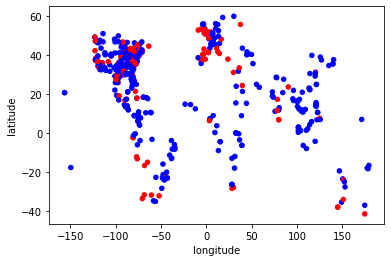

In [28]:
df[['latitude','longitude']].plot.scatter(x='longitude',y='latitude',c=colors)
# color of the dot is set by the number of same-named cities; this may be a clue that it's in the wrong place

In [29]:
# Plot all cities on a map

all_lat = list(df['latitude'])
all_lon = list(df['longitude'])

print('type is {} and {}'.format(type(all_lat), type(all_lat[0])))
# plotting is going to want these to be python float, not np.float64, so convert to list

type is <class 'list'> and <class 'float'>


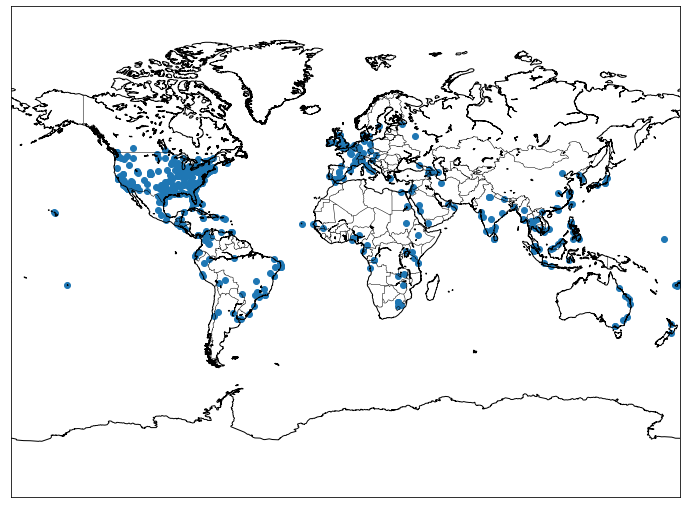

In [30]:
fig = plt.figure(figsize=(12, 10))
if (0):
    map_plotter = Basemap(projection='ortho',lat_0=40, lon_0=-95)  # projection options: ortho, lcc

else:
    map_plotter = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
           llcrnrlon = -180, urcrnrlon=180,resolution='l')


map_plotter.scatter(all_lon,\
                    all_lat,\
                    latlon=True)
map_plotter.drawcoastlines()
map_plotter.drawcountries()
plt.show()

In [31]:
# Didn't check that headlines with the country listed ended up with the correct country...did they?
df[df['country'].notna()]
# Yes, they did, but it would be wise to add the check in the future; it may help identify an 
# incorrectly chosen city if there were others of the same name

,headline,city,country,latitude,longitude,cityduplicates,countrycode
4,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,Vietnam,10.82302,106.62965,1,VN
34,"New Zika Case in Kota Kinabalu, Malaysia",Kota Kinabalu,Malaysia,5.97490,116.07240,1,MY
76,"Zika reaches Johor Bahru, Malaysia",Johor Bahru,Malaysia,1.46550,103.75780,1,MY
178,"Zika outbreak in Piracicaba, Brazil",Piracicaba,Brazil,-22.72528,-47.64917,1,BR
279,"Student sick in Campinas, Brazil",Campinas,Brazil,-22.90556,-47.06083,2,BR
348,Thailand-Zika Virus in Bangkok,Bangkok,Thailand,13.75398,100.50144,1,TH
478,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,1,BR
575,"Zika surfaces in Klang, Malaysia",Klang,Malaysia,3.03667,101.44333,1,MY


In [32]:
df.to_csv('headlines_lat_long_cc.csv',index=False)